# BitNetTransformer

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torchinfo import summary
from bitnet import BitNetTransformer

from app.utils import clear_memory

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Bertimbau Tokenizer & Embeddings

In [4]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel

huggingface_model = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(huggingface_model)
model = AutoModel.from_pretrained(huggingface_model)
feature_extractor = pipeline('feature-extraction', model=model, tokenizer=tokenizer)
embeddings = model.get_input_embeddings()

In [5]:
print(tokenizer.vocab_size)
print(embeddings.embedding_dim)

29794
768


Comparando diferentes maneiras de transformar texto para embbedings

In [6]:
sentence = 'O advogado apresentou recurso para o juíz'

# a. contextualized embeddings c/ feature_extractor: texto tokenizado automaticamente, passa para embedding, encoder e attention layers antes
sentence_embeddings1 = feature_extractor(sentence)

with torch.inference_mode():
    sentence_tokenized = tokenizer(sentence, return_tensors="pt")
    sentence_input_ids = sentence_tokenized["input_ids"]
    sentence_attention_mask = sentence_tokenized["attention_mask"]

    # b. non-contextualized embeddings com embedding layer do bertimbau: usa embbeding layer 
    # antes de passar na rede transformer, ou seja, sem passar pelo encoder e attention layers
    sentence_embeddings2 = embeddings(sentence_input_ids)

    # c. a mesma coisa da primeira abordagem só que mais explicita, sem as facilidades do pipeline
    sentence_embeddings3 = model(input_ids=sentence_input_ids, 
                                attention_mask=sentence_attention_mask
                                ).last_hidden_state
    

In [7]:
print("Batch sizes:")
print(len(sentence_embeddings1))
print(len(sentence_embeddings2))
print(len(sentence_embeddings3))

print("Sequence Lengths:")
print(len(sentence_embeddings1[0]))
print(len(sentence_embeddings2[0]))
print(len(sentence_embeddings3[0]))

print("BERT Hidden Size:")
print(len(sentence_embeddings1[0][0]))
print(len(sentence_embeddings2[0][0]))
print(len(sentence_embeddings3[0][0]))

print("Embeddings Types:")
print(type(sentence_embeddings1[0][0]))
print(type(sentence_embeddings2[0][0]))
print(type(sentence_embeddings3[0][0]))

print("Embeddings Values:")
print(torch.tensor(sentence_embeddings1[0][0][:5]))
print(sentence_embeddings2[0][0][:5])
print(sentence_embeddings3[0][0][:5])


Batch sizes:
1
1
1
Sequence Lengths:
10
10
10
BERT Hidden Size:
768
768
768
Embeddings Types:
<class 'list'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Embeddings Values:
tensor([ 0.6715, -0.3474, -0.1421, -0.0567,  0.8103])
tensor([-0.0004,  0.0014,  0.0251,  0.0272, -0.0022])
tensor([ 0.6715, -0.3474, -0.1421, -0.0567,  0.8103])


Vamos testar os modelos na sentença 'Olá Mundo!', mas antes temos que preparar o input corretamente para os modelos.

In [8]:
texto = 'Olá Mundo!'

Usando tamanho do vocabulário igual ao do tokenizer ou o tamanho dos embeddings?

In [9]:
print(tokenizer.vocab_size)
print(embeddings.embedding_dim)

29794
768


In [10]:
VOCAB_SIZE = 29794
D_MODEL = 128

Convertendo o texto p/ token_ids (entradas das 2 redes)

In [11]:
input_ids = tokenizer(texto, 
                      return_tensors="pt"
                      ).input_ids

input_ids = input_ids
print(input_ids.shape)
print(input_ids[0,:5])

torch.Size([1, 6])
tensor([  101,  1651, 22303,  3327,   106])


### Wikipedia Dataset and Dataloader

In [12]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from datasets import load_dataset

In [13]:
# Load the dataset
train_dataset = load_dataset("Luciano/lener_br_text_to_lm", 
                             split="train[:100%]")  # Use 100% for a smaller dataset

test_dataset = load_dataset("Luciano/lener_br_text_to_lm", 
                            split="test[:100%]")  # Use 100% for a smaller dataset

print("Número de documentos no dataset de treino:", len(train_dataset))
print("Número de documentos no dataset de teste:", len(test_dataset))

Número de documentos no dataset de treino: 8316
Número de documentos no dataset de teste: 2079


Analisando quantidade de tokens por sequência

In [14]:
from collections import Counter
import pandas as pd

counter = Counter()

def input_ids_extractor(examples):
    tokens = tokenizer(examples['text'], truncation=False, return_tensors="pt")
    return {"input_ids": tokens["input_ids"]}

df = pd.DataFrame(train_dataset)
n_tokens = []
for x in train_dataset.map(input_ids_extractor, remove_columns=train_dataset.column_names)["input_ids"]:
    n_tokens.append(len(x[0]))
    counter.update(x[0])
    
df["n_tokens"] = n_tokens
df

,text,n_tokens
0,Seria o mesmo que dizer que o trabalhador tem ...,83
1,O autor sustenta que a lei é formal e material...,226
2,Esse juízo decorre do fato de que o exame de c...,73
3,"Apesar , de o próprio responsável apresentar c...",24
4,"Quando de sua assunção à direção do STM , esta...",67
...,...,...
8311,"No ponto , convém salientar que o Supremo Trib...",154
8312,"Em relação ao subitem 9.2.1 , o GAP/BR informa...",53
8313,4 .,4
8314,O agravante limitou-se a reprisar os argumento...,42


<Axes: >

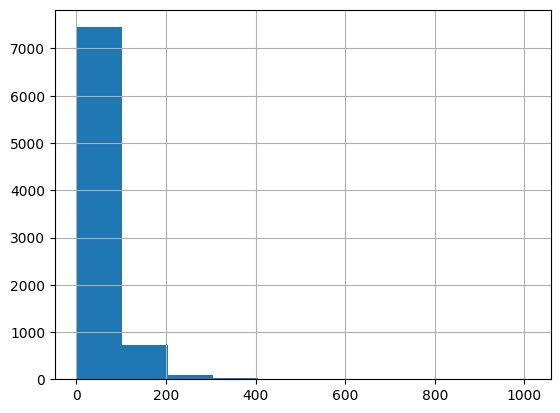

In [15]:
df["n_tokens"].hist()

In [16]:
df["n_tokens"].describe()

count    8316.000000
mean       48.716450
std        53.066798
min         2.000000
25%        15.000000
50%        35.000000
75%        64.000000
max      1009.000000
Name: n_tokens, dtype: float64

Listando tokens mais frequentes

In [17]:
counter.most_common(10)

[(117, 18875),
 (119, 17256),
 (125, 10438),
 (101, 8316),
 (102, 8316),
 (123, 6859),
 (171, 5852),
 (180, 5018),
 (118, 4854),
 (146, 4847)]

In [18]:
def preprocess_function(examples):
    tokens = tokenizer(examples['text'], truncation=True, padding="max_length", max_length=D_MODEL, return_tensors="pt")
    return {
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"]
    }

train_tokenized_dataset = train_dataset.map(preprocess_function, 
                                            batched=True, 
                                            remove_columns=train_dataset.column_names)

test_tokenized_dataset = test_dataset.map(preprocess_function, 
                                          batched=True, 
                                          remove_columns=test_dataset.column_names)

Map:   0%|          | 0/2079 [00:00<?, ? examples/s]

In [19]:
BATCH_SIZE = 32

In [20]:
import os

# está dando problema de concorrência 
NUM_WORKERS = 0 # os.cpu_count()

# TODO verificar se realmente precisa disso
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create DataLoader
train_dataloader = DataLoader(train_tokenized_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              collate_fn=data_collator,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_tokenized_dataset, 
                             batch_size=BATCH_SIZE, 
                             shuffle=True, 
                             collate_fn=data_collator,
                             num_workers=NUM_WORKERS)

In [21]:

print("Número de batches no conjunto de treinamento:", len(train_dataloader))
print("Número de batches no conjunto de testes:", len(test_dataloader))

Número de batches no conjunto de treinamento: 260
Número de batches no conjunto de testes: 65


In [22]:
sample_batch = next(iter(train_dataloader))
print(sample_batch.keys())
print(len(sample_batch["input_ids"][0]))
print(len(sample_batch["attention_mask"][0]))

dict_keys(['input_ids', 'attention_mask'])
128
128


### bitnet.BitnetTransformer

Come será visto no resultado do summary, o BitNetTransformet já tem uma camada de embeddings incorporada na arquitetura do modelo.

In [23]:
bitnet = BitNetTransformer(
    num_tokens=VOCAB_SIZE,  # Number of unique tokens in the input
    dim=D_MODEL,  # Dimension of the input and output embeddings
    depth=6,  # Number of transformer layers
    # heads=8,  # Number of attention heads
    # ff_mult=4,  # Multiplier for the hidden dimension in the feed-forward network
)

summary(model= bitnet,
        col_names=["num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Param #              Trainable
BitNetTransformer (BitNetTransformer)         --                   True
├─Embedding (emb)                             3,813,632            True
├─Transformer (transformer)                   --                   True
│    └─ModuleList (layers)                    --                   True
│    │    └─BitMGQA (0)                       41,472               True
│    │    └─BitMGQA (1)                       41,472               True
│    │    └─BitMGQA (2)                       41,472               True
│    │    └─BitMGQA (3)                       41,472               True
│    │    └─BitMGQA (4)                       41,472               True
│    │    └─BitMGQA (5)                       41,472               True
│    └─ModuleList (ffn_layers)                --                   True
│    │    └─BitFeedForward (0)                132,736              True
│    │    └─BitFeedForward (1)                132,736      

In [24]:
clear_memory()

In [25]:

bitnet.eval()
with torch.inference_mode():
    bitnet_logits = bitnet(input_ids)

print(bitnet_logits.shape)
print(bitnet_logits[0,:5])

torch.Size([1, 6, 29794])
tensor([[ 0.5085, -0.6503, -1.1062,  ..., -0.1293,  0.1022, -0.5735],
        [-0.5492,  0.5070, -0.5195,  ..., -0.5236,  0.0432, -1.0312],
        [-0.0328,  1.2148, -1.3053,  ...,  0.7044,  0.2015,  0.0189],
        [-0.9169,  0.5775, -0.1931,  ..., -0.9075,  0.0480, -0.7307],
        [ 0.1907,  0.4106, -0.0051,  ...,  0.5293, -0.2727, -0.8493]])


### torch.nn.Transformer

In [26]:
# estou usando a implementaçao da bitnet pq no torch '2.2.0+cu121' não tem implementado ainda
from bitnet.bit_transformer import RMSNorm

class BaseTransformerModel(nn.Module):
    def __init__(
        self,
        dim: int,
        depth: int,
        num_tokens: int,
        heads=8,
        ff_mult=4,
    ):
        super().__init__()
        self.emb = nn.Embedding(num_tokens, dim)
        
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=dim, nhead=heads),
            num_layers=1
        )

        self.to_logits = nn.Sequential(
            RMSNorm(dim),
            nn.Linear(dim, num_tokens)
        )

    def forward(self, x):
        # embeddings sem positional encoding somados
        x = self.emb(x)
        x = self.decoder(tgt=x, memory=x)
        return self.to_logits(x)

In [27]:
baseline = BaseTransformerModel(
    num_tokens=VOCAB_SIZE,  # Number of unique tokens in the input
    dim=D_MODEL,  # Dimension of the input and output embeddings
    depth=6,  # Number of transformer layers
    heads=8,  # Number of attention heads
    # ff_mult=4,  # Multiplier for the hidden dimension in the feed-forward network
    )

# c/ parâmetro input_size aloca 200MB de memória e não desaloca depois
summary(model= baseline,
        #input_size=(src_size, tgt_size),
        #col_names=["input_size", "output_size", "num_params", "trainable"],
        col_names=["num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                                Param #              Trainable
BaseTransformerModel (BaseTransformerModel)                            --                   True
├─Embedding (emb)                                                      3,813,632            True
├─TransformerDecoder (decoder)                                         --                   True
│    └─ModuleList (layers)                                             --                   True
│    │    └─TransformerDecoderLayer (0)                                659,328              True
├─Sequential (to_logits)                                               --                   True
│    └─RMSNorm (0)                                                     128                  True
│    └─Linear (1)                                                      3,843,426            True
Total params: 8,316,514
Trainable params: 8,316,514
Non-trainable params: 0

In [28]:
clear_memory()

In [29]:
baseline.eval()
with torch.inference_mode():
    base_logits = baseline(input_ids)

print(base_logits.shape)
print(base_logits[0,:5])

torch.Size([1, 6, 29794])
tensor([[ 0.7746, -0.7232,  1.4470,  ..., -0.1024,  0.1412, -0.3216],
        [ 0.3558, -0.0813, -0.7195,  ..., -0.2602,  0.6809,  0.7711],
        [ 0.3628, -0.3117, -1.3188,  ..., -0.5278, -0.0926,  0.3631],
        [-1.0238, -0.5662,  0.3112,  ..., -0.2797,  0.7438,  0.1896],
        [ 0.7988,  0.2760, -0.1603,  ...,  0.5104, -0.2167,  0.0705]])


In [30]:
clear_memory()

### Training Loop

In [31]:

# Set up optimizer and learning rate scheduler


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          criteria: torch.nn.functional.cross_entropy,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: str = device):
    
    results = {"train_loss": [], "test_loss": []}

    for epoch in range(epochs):

        epoch_train_loss = 0
        epoch_test_loss = 0

        # Training loop
        model.train()
        for batch, data in enumerate(train_dataloader):
            optimizer.zero_grad()
            # pode pegar as attention masks também
            input_ids = data["input_ids"].to(device)

            # Forward pass
            outputs = model(input_ids)  

            # Calculate the loss
            loss = criteria(outputs.view(-1, VOCAB_SIZE), input_ids.view(-1))
            epoch_train_loss += loss.item()
            
            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()  

            if batch % 100 == 0:
                # printando número de batches
                print(f"Batch: {batch}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

        # Test loop
        model.eval()
        with torch.inference_mode():
            for test_batch, test_data in enumerate(test_dataloader):
                test_input_ids = test_data["input_ids"].to(device)

                test_outputs = model(test_input_ids)
                test_loss = criteria(test_outputs.view(-1, VOCAB_SIZE), test_input_ids.view(-1))
                epoch_test_loss += test_loss.item()
                
                if batch % 100 == 0:
                    # printando número de batches de teste
                    print(f"Batch: {test_batch}/{len(test_dataloader)}, Test Loss: {test_loss.item():.4f}")

        # printando loss após o final de uma época de treinamento        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

        results["train_loss"].append(epoch_train_loss)
        results["test_loss"].append(epoch_test_loss)

    return results
    
    

In [32]:
EPOCHS = 5
LEARNING_RATE = 5e-5
DEFAULT_LOSS = torch.nn.functional.cross_entropy

In [33]:
clear_memory()

baseline = baseline.to(device)

In [34]:

optimizer = torch.optim.AdamW(baseline.parameters(), lr=LEARNING_RATE)

baseline_results = train(model = baseline,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         criteria=DEFAULT_LOSS,
                         optimizer=optimizer,
                         epochs = EPOCHS,
                         device = device)

Batch: 0/260, Loss: 10.4627
Batch: 100/260, Loss: 5.4199
Batch: 200/260, Loss: 4.5337
Epoch 1/5, Loss: 3.502687692642212
Batch: 0/260, Loss: 3.5834
Batch: 100/260, Loss: 2.7876
Batch: 200/260, Loss: 2.2942
Epoch 2/5, Loss: 2.3807220458984375
Batch: 0/260, Loss: 2.5381
Batch: 100/260, Loss: 1.9782
Batch: 200/260, Loss: 2.0067
Epoch 3/5, Loss: 2.1239449977874756
Batch: 0/260, Loss: 2.1452
Batch: 100/260, Loss: 1.6920
Batch: 200/260, Loss: 1.5739
Epoch 4/5, Loss: 1.1545331478118896
Batch: 0/260, Loss: 1.7413
Batch: 100/260, Loss: 1.5599
Batch: 200/260, Loss: 1.3186
Epoch 5/5, Loss: 1.3246814012527466


In [35]:
clear_memory()

bitnet = bitnet.to(device)

In [36]:
optimizer = torch.optim.AdamW(bitnet.parameters(), lr=LEARNING_RATE)

bitnet_results = train(model = bitnet,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       criteria = DEFAULT_LOSS,
                       optimizer = optimizer,
                       epochs = EPOCHS,
                       device = device)

Batch: 0/260, Loss: 10.6764
Batch: 100/260, Loss: 9.8567
Batch: 200/260, Loss: 9.0441
Epoch 1/5, Loss: 8.476499557495117
Batch: 0/260, Loss: 8.6132
Batch: 100/260, Loss: 7.6309
Batch: 200/260, Loss: 6.7194
Epoch 2/5, Loss: 6.581727504730225
Batch: 0/260, Loss: 6.2426
Batch: 100/260, Loss: 5.6193
Batch: 200/260, Loss: 4.9835
Epoch 3/5, Loss: 4.457399845123291
Batch: 0/260, Loss: 4.5872
Batch: 100/260, Loss: 3.3761
Batch: 200/260, Loss: 2.9851
Epoch 4/5, Loss: 2.79992938041687
Batch: 0/260, Loss: 3.2453
Batch: 100/260, Loss: 2.2316
Batch: 200/260, Loss: 2.0965
Epoch 5/5, Loss: 2.43396258354187


In [37]:
# Save models
torch.save(baseline, "./models/baseline_transformer.pt")

torch.save(bitnet, "./models/bitnet_transformer.pt")

### Geração de Texto

In [38]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer

def generate_text(model, tokenizer, prompt, max_length=50, temperature=1.0):
    """
    Generates text using an autoregressive approach with a Transformer model.
    
    Args:
        model (nn.Module): The autoregressive Transformer model.
        tokenizer (AutoTokenizer): The tokenizer for encoding and decoding text.
        prompt (str): The initial text prompt to start the generation.
        max_length (int): Maximum length of the generated text.
        temperature (float): Temperature value for sampling (higher = more randomness).
    
    Returns:
        str: The generated text.
    """
    # Encode the input prompt into token IDs
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids

    # Move input_ids to the same device as the model (CPU/GPU)
    input_ids = input_ids.to(next(model.parameters()).device)

    # Initialize a list to store generated tokens
    generated_ids = input_ids.clone()

    # Set the model to evaluation mode
    model.eval()

    # Use a loop to generate tokens one by one
    with torch.no_grad():
        for _ in range(max_length):
            # Get the model's logits for the next token
            output = model(generated_ids)

            logits = output[:, -1, :]  # Take the logits of the last token

            # Apply temperature scaling to logits if temperature is specified
            logits = logits / temperature

            # Use softmax to get probabilities and sample the next token id
            probs = torch.nn.functional.softmax(logits, dim=-1)
            next_token_id = torch.multinomial(probs, num_samples=1)

            # Append the predicted token id to the generated_ids
            generated_ids = torch.cat([generated_ids, next_token_id], dim=-1)

            # If the model generates the EOS (end-of-sequence) token, stop early
            if next_token_id.item() == tokenizer.eos_token_id:
                break

    # Decode the generated token IDs back into a string
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return generated_text


In [39]:
# Example prompt and text generation
prompt = "O autor sustenta que a lei é formal"

bitnet_generated_text = generate_text(model=bitnet, 
                               tokenizer=tokenizer, 
                               prompt=prompt, 
                               max_length=20, 
                               temperature=0.8)


baseline_generated_text = generate_text(model=baseline, 
                               tokenizer=tokenizer, 
                               prompt=prompt, 
                               max_length=20, 
                               temperature=0.8)


print(bitnet_generated_text)
print(baseline_generated_text)

O autor sustenta que a lei é formalRei reque atua tentadocrimin Fox mostrada honra។ Hend sustentação Federal運ensteinansãoíticos lavagem mecânicoíficos
O autor sustenta que a lei é formal


In [40]:
baseline = baseline.to("cpu")
bitnet = bitnet.to("cpu")

In [41]:
clear_memory()

Carregando modelos salvos

In [56]:
loaded_baseline = torch.load("./models/baseline_transformer.pt", 
                             weights_only=False)

loaded_bitnet = torch.load("./models/bitnet_transformer.pt", 
                           weights_only=False)

In [60]:
baseline_generated_text = generate_text(model=loaded_baseline, 
                               tokenizer=tokenizer, 
                               prompt=prompt, 
                               max_length=20, 
                               temperature=0.8)

bitnet_generated_text = generate_text(model=loaded_bitnet, 
                               tokenizer=tokenizer, 
                               prompt=prompt, 
                               max_length=20, 
                               temperature=0.8)

print(bitnet_generated_text)
print(baseline_generated_text)

O autor sustenta que a lei é formal Wild Sele inic significadoteriores♯ nos passageirosntimento atos curiosidadeificadoreuro Pack恩스螂 igrejas incorpora fam
O autor sustenta que a lei é formal
